In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.notebook import tqdm
import torch.autograd as autograd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = torch.load("../64torchiodataset.pt")


# lengths = [
#     int(len(dataset) * 0.8),
#     int(len(dataset) * 0.1),
#     int(len(dataset) * 0.1) + 1
# ]

# trainset, valset, testset = random_split(dataset, lengths)
# image_datasets = {'train': trainset, 'val': valset, 'test': testset}
# dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
#               for x in ['train', 'val', 'test']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}  


NC = []
AD = []
for data in dataset:
    if data[1] == 0:
        NC.append(data)
    else:
        AD.append(data)
        
NC = [sample[0] for sample in NC]
NCgan1 = [torch.unsqueeze(sample[0][0], 0) for sample in NC]
NCgan2 = [torch.unsqueeze(sample[1][0], 0) for sample in NC]
NCgan3 = [torch.unsqueeze(sample[2][0], 0) for sample in NC]

batch_size = 16
dataloader1 = DataLoader(NCgan1[:-1], batch_size=batch_size, shuffle=True, num_workers=4)
dataloader2 = DataLoader(NCgan2[:-1], batch_size=batch_size, shuffle=True, num_workers=4)
dataloader3 = DataLoader(NCgan3[:-1], batch_size=batch_size, shuffle=True, num_workers=4)

In [2]:
import os
import numpy as np
import math
import sys
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

n_epochs = 200
lr= 0.00005
n_cpu = 8
latent_dim = 100
img_size = 64
channels = 1
clip_value = 0.005
sample_interval = 400


img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

dataset_name = 'WGAN'
os.makedirs("images/%s" % dataset_name, exist_ok=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

    
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [8]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()
lambda_gp = 10


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

img_grids = []
images = []
G_losses = []
D_losses = []

def train_gan(dataloader):
    batches_done = 0
    for epoch in range(n_epochs):

        for i, imgs in enumerate(dataloader):

            real_imgs = Variable(imgs.type(Tensor))


            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

            # Generate a batch of images
            fake_imgs = generator(z).detach()
            
            real_validity = discriminator(real_imgs)
            # Fake images
            fake_validity = discriminator(fake_imgs)
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
            # Adversarial loss
            loss_D = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
            
            loss_D.backward()
            optimizer_D.step()

            # Clip weights of discriminator
#             for p in discriminator.parameters():
#                 p.data.clamp_(-clip_value, clip_value)

            # Train the generator every n_critic iterations
            if i % 5 == 0:

                # -----------------
                #  Train Generator
                # -----------------

                optimizer_G.zero_grad()

                # Generate a batch of images
                gen_imgs = generator(z)
                # Adversarial loss
                fake_validity = discriminator(fake_imgs)
                loss_G = -torch.mean(fake_validity)

                loss_G.backward()
                optimizer_G.step()

            
            if batches_done % sample_interval == 0:
                save_image(gen_imgs.data[:16], f"images/WGAN/{batches_done}.png", nrow=4, normalize=True)
                with torch.no_grad():
                    fake = generator(z).detach().cpu()
                img_grids.append(vutils.make_grid(fake, padding=2, normalize=True))
                for sample in fake:
                    images.append(sample)
                    
            batches_done += 1        
            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())
            
        print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
            )

        
train_gan(dataloader1)

[Epoch 0/200] [Batch 0/44] [D loss: -63.766079] [G loss: -0.005870]
[Epoch 1/200] [Batch 0/44] [D loss: -143.906738] [G loss: 0.195555]
[Epoch 2/200] [Batch 0/44] [D loss: -138.519226] [G loss: 0.561999]
[Epoch 3/200] [Batch 0/44] [D loss: -157.078094] [G loss: 1.037112]
[Epoch 4/200] [Batch 0/44] [D loss: -142.504456] [G loss: 1.290002]
[Epoch 5/200] [Batch 0/44] [D loss: -149.059967] [G loss: 1.671337]
[Epoch 6/200] [Batch 0/44] [D loss: -169.262650] [G loss: 1.819667]
[Epoch 7/200] [Batch 0/44] [D loss: -148.387360] [G loss: 1.938491]
[Epoch 8/200] [Batch 0/44] [D loss: -162.670013] [G loss: 1.788250]
[Epoch 9/200] [Batch 0/44] [D loss: -145.373962] [G loss: 1.102524]
[Epoch 10/200] [Batch 0/44] [D loss: -154.360992] [G loss: 0.498931]
[Epoch 11/200] [Batch 0/44] [D loss: -155.976791] [G loss: 0.298678]
[Epoch 12/200] [Batch 0/44] [D loss: -148.867554] [G loss: 0.217426]
[Epoch 13/200] [Batch 0/44] [D loss: -146.206024] [G loss: 0.166444]
[Epoch 14/200] [Batch 0/44] [D loss: -168.83

KeyboardInterrupt: 

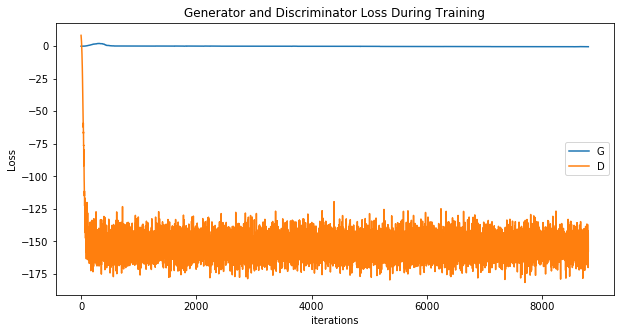

In [4]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

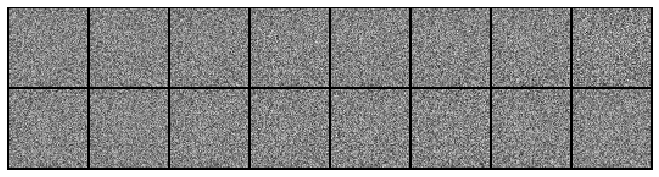

In [5]:
fig = plt.figure(figsize=(12,3))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_grids]
ani = animation.ArtistAnimation(fig, ims, interval= 500, repeat_delay=50, blit=True)

HTML(ani.to_jshtml())

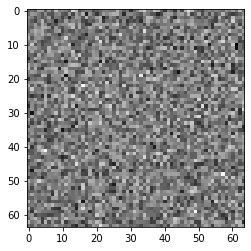

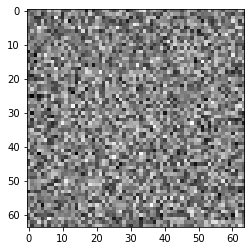

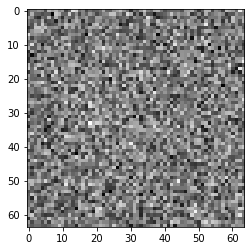

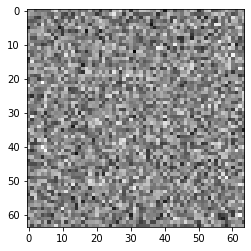

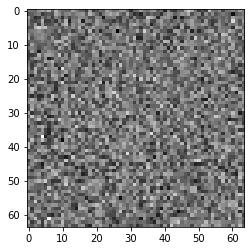

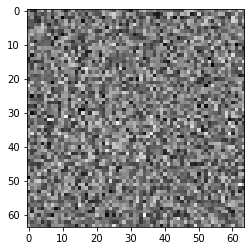

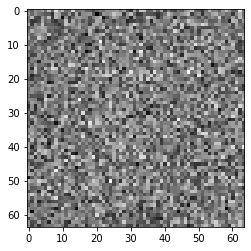

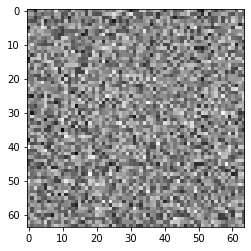

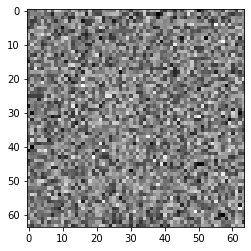

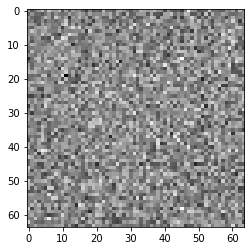

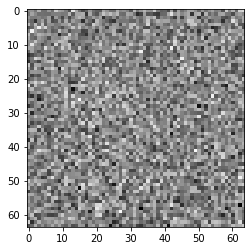

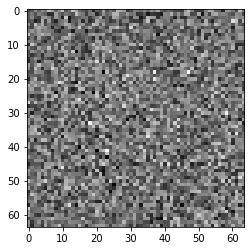

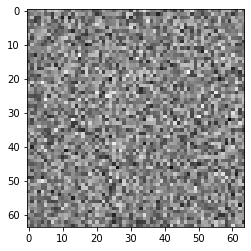

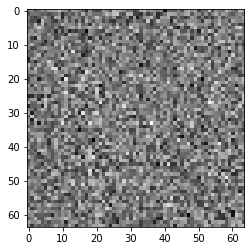

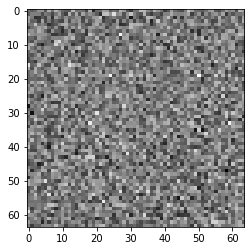

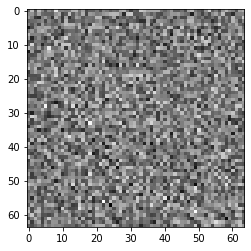

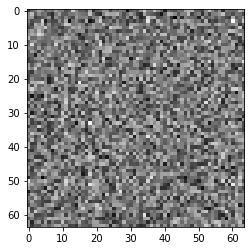

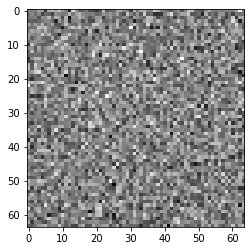

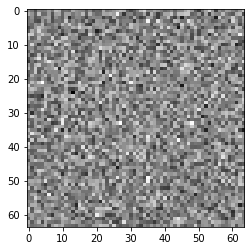

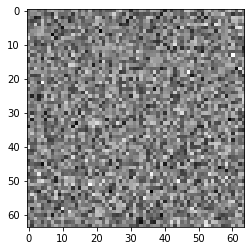

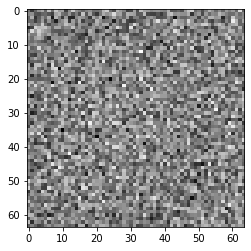

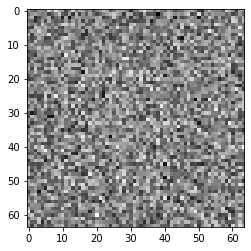

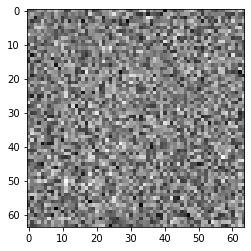

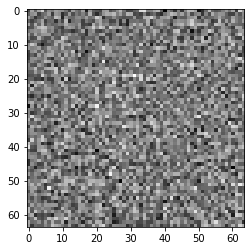

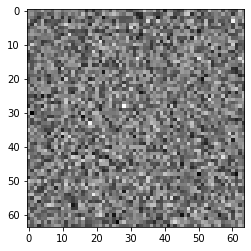

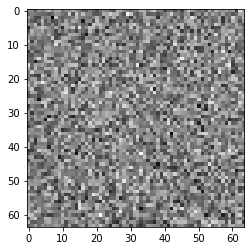

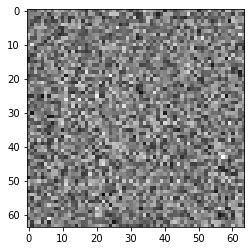

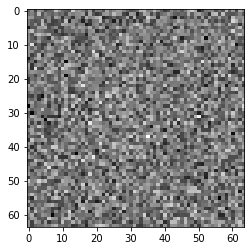

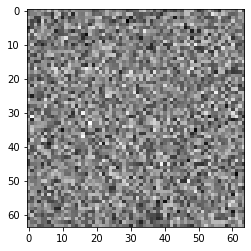

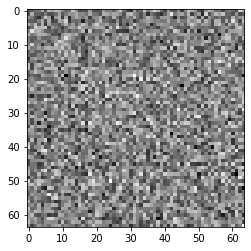

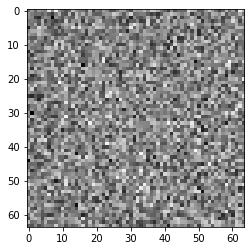

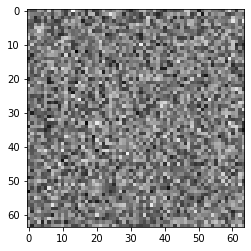

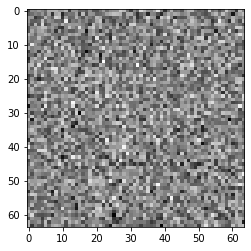

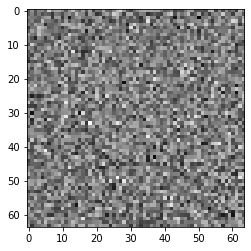

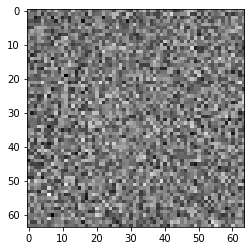

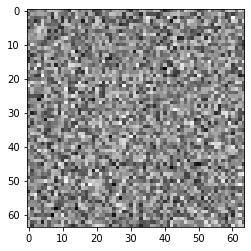

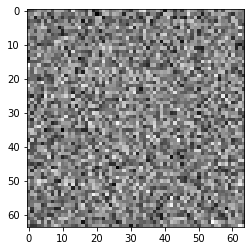

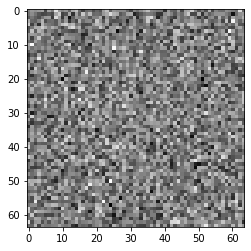

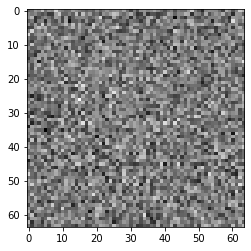

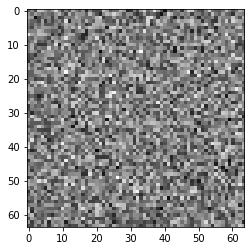

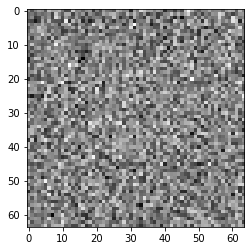

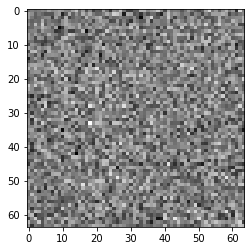

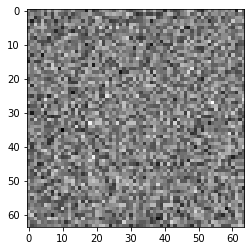

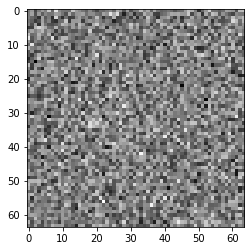

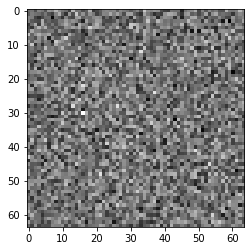

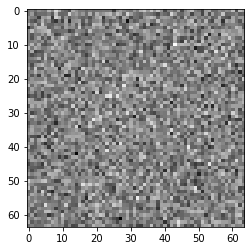

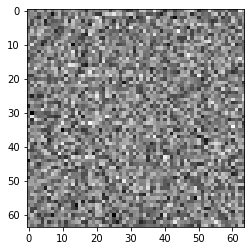

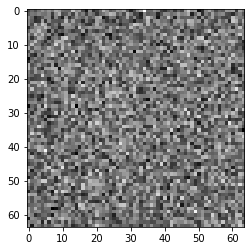

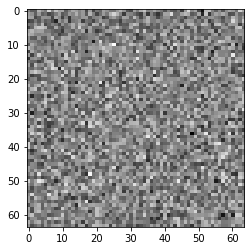

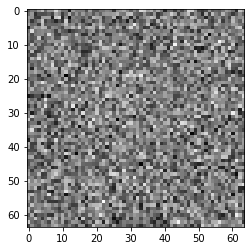

In [6]:
for i in tqdm(range(50)):
    plt.imshow(images[-i].reshape(64, 64), cmap = 'gray')
    plt.show()

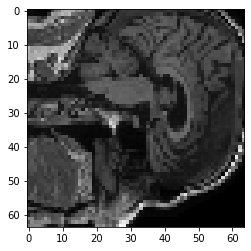

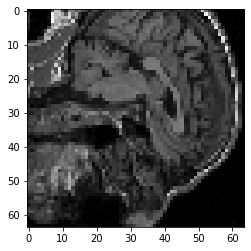

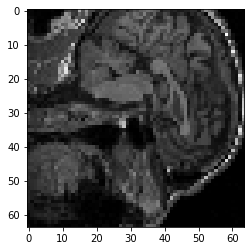

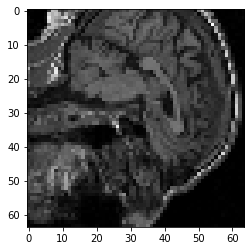

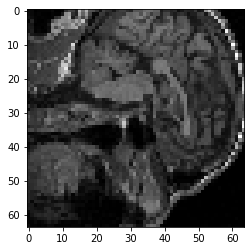

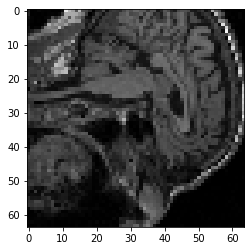

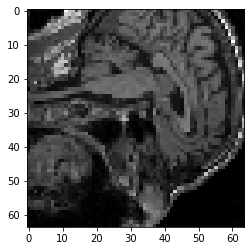

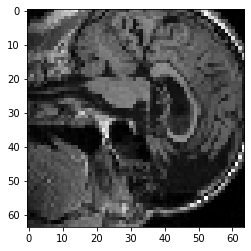

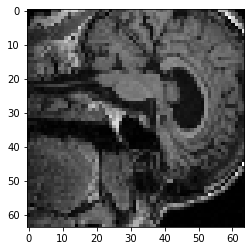

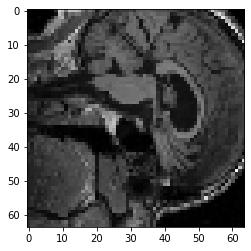

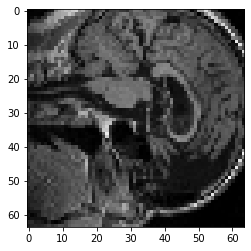

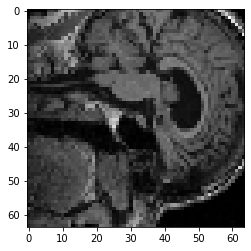

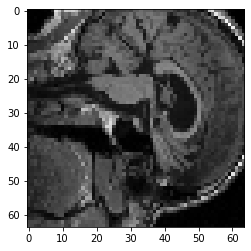

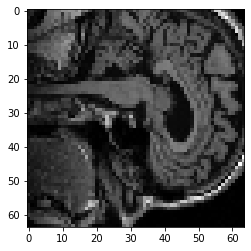

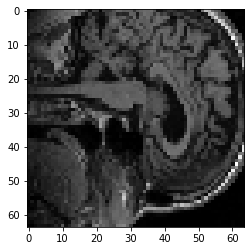

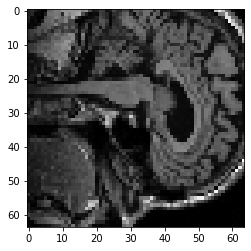

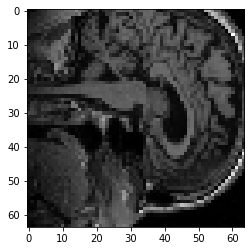

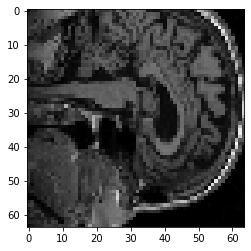

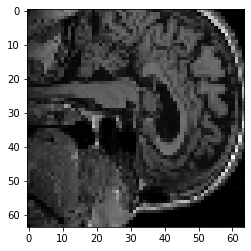

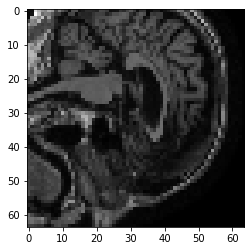

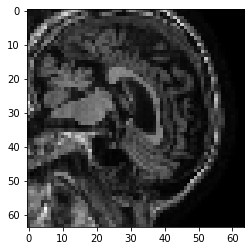

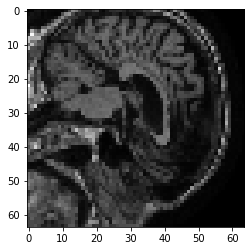

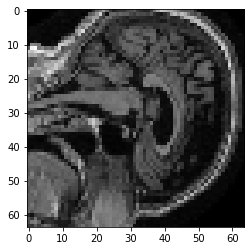

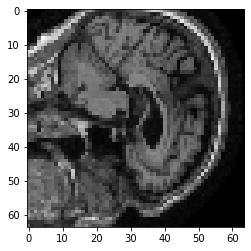

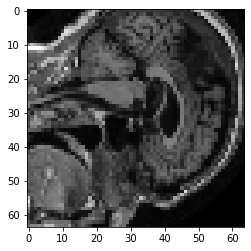

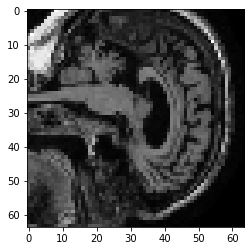

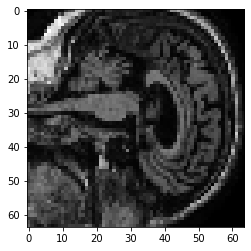

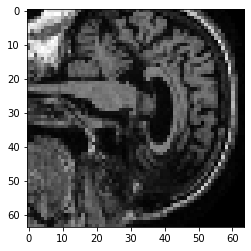

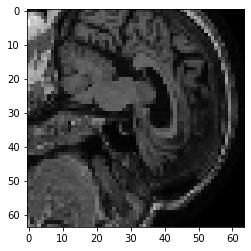

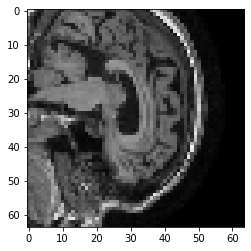

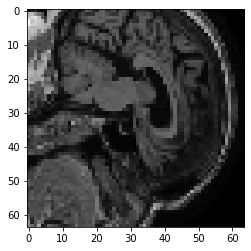

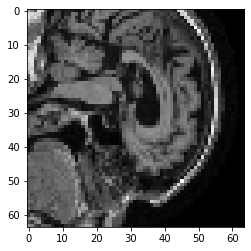

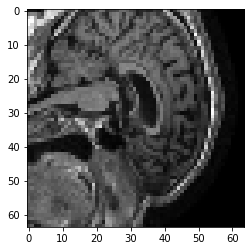

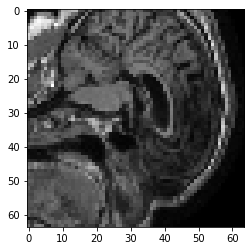

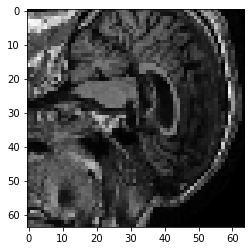

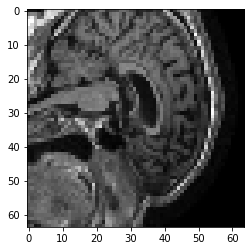

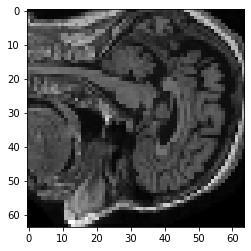

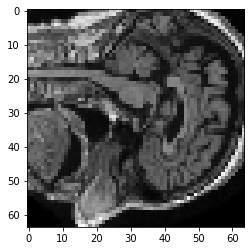

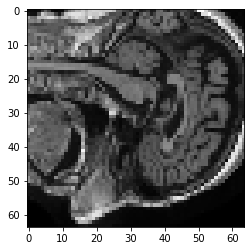

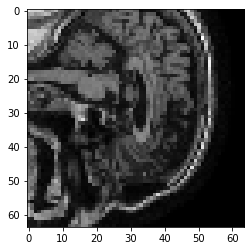

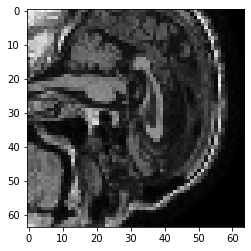

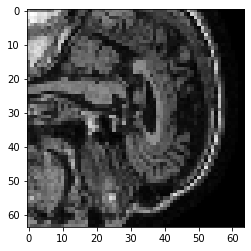

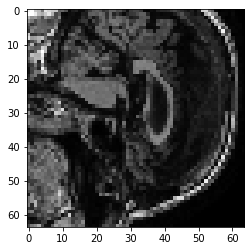

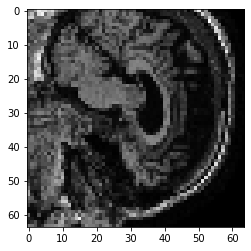

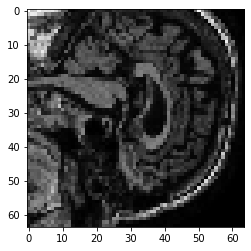

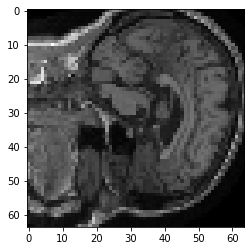

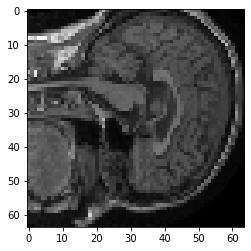

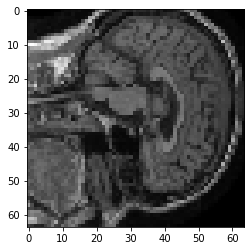

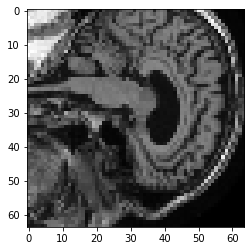

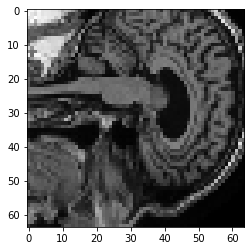

In [7]:
for i in tqdm(range(50)):
    plt.imshow(NCgan1[-i].reshape(64, 64), cmap = 'gray')
    plt.show()